In [19]:
import warnings
warnings.filterwarnings('ignore')

# Import package
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import pandas as pd 
import statsmodels.api as sm
from matplotlib import rcParams
from matplotlib import cm
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tabulate import tabulate
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
rcParams.update({'font.size': 18})
from scipy.stats import norm

In [22]:
# data
advertising = pd.read_csv("fbdata.csv")
print(advertising.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_id                1143 non-null   int64  
 1   xyz_campaign_id      1143 non-null   int64  
 2   fb_campaign_id       1143 non-null   int64  
 3   age                  1143 non-null   object 
 4   gender               1143 non-null   object 
 5   interest             1143 non-null   int64  
 6   Impressions          1143 non-null   int64  
 7   Clicks               1143 non-null   int64  
 8   Spent                1143 non-null   float64
 9   Total_Conversion     1143 non-null   int64  
 10  Approved_Conversion  1143 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 98.4+ KB
None


In [23]:
# Replace character string age ranges with number
advertising.loc[advertising['age'] == '30-34', 'age'] = 32
advertising.loc[advertising['age'] == '35-39', 'age'] = 37
advertising.loc[advertising['age'] == '40-44', 'age'] = 42
advertising.loc[advertising['age'] == '45-49', 'age'] = 47

# Convert gender variable to integer
advertising['gender'] = advertising['gender'].replace({'M': 0, 'F': 1})
advertising['gender'] = advertising['gender'].astype(int)



In [24]:
# clean up column names that contain whitespace
advertising.columns = advertising.columns.str.replace(' ', '')
advertising.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,32,0,15,7350,1,1.43,2,1
1,708749,916,103917,32,0,16,17861,2,1.82,2,0
2,708771,916,103920,32,0,20,693,0,0.00,1,0
3,708815,916,103928,32,0,28,4259,1,1.25,1,0
4,708818,916,103928,32,0,28,4133,1,1.29,1,1


In [25]:
# abbreviate some variable names
advertising.fillna(0, inplace=True)
advertising = advertising.rename(columns={"Total_Conversion": "conv", "Impressions": "impr", "Approved_Conversion": "appConv", "xyz_campaign_id": "xyzID", "fb_campaign_id": "fbID" })
print(advertising.head())

    ad_id  xyzID    fbID age  gender  interest   impr  Clicks  Spent  conv  \
0  708746    916  103916  32       0        15   7350       1   1.43     2   
1  708749    916  103917  32       0        16  17861       2   1.82     2   
2  708771    916  103920  32       0        20    693       0   0.00     1   
3  708815    916  103928  32       0        28   4259       1   1.25     1   
4  708818    916  103928  32       0        28   4133       1   1.29     1   

   appConv  
0        1  
1        0  
2        0  
3        0  
4        1  


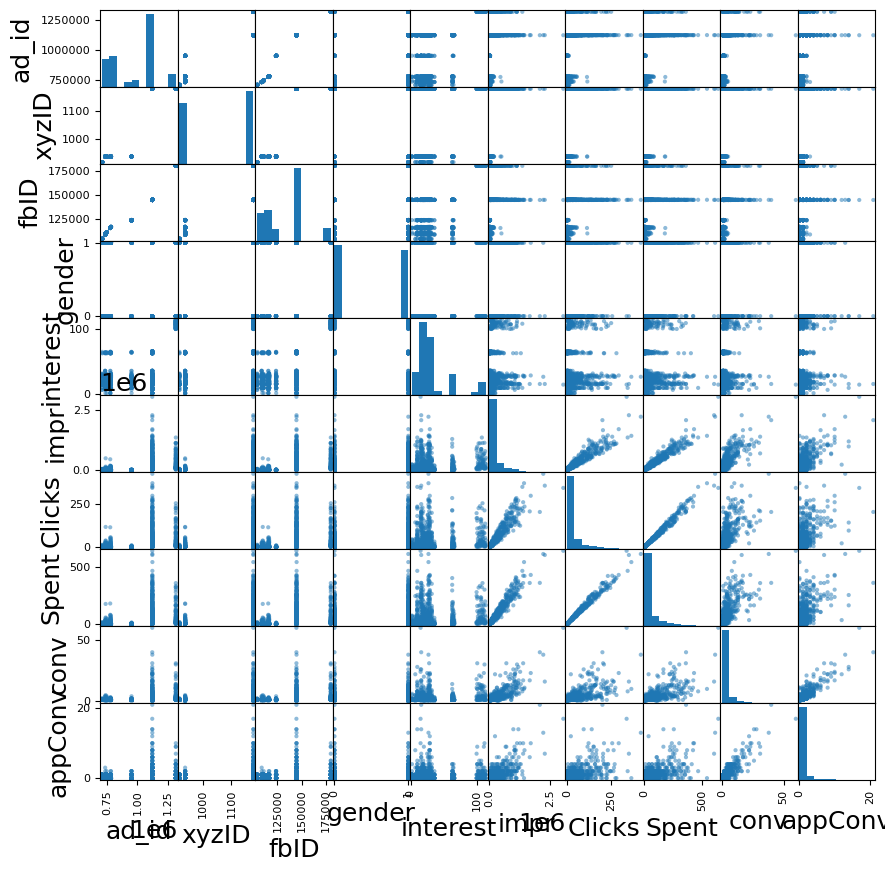

In [9]:
# scatter plor
pd.plotting.scatter_matrix(advertising, figsize=(10, 10))
plt.show()

In [26]:
print(advertising['Spent'].skew())

2.7088670200884732


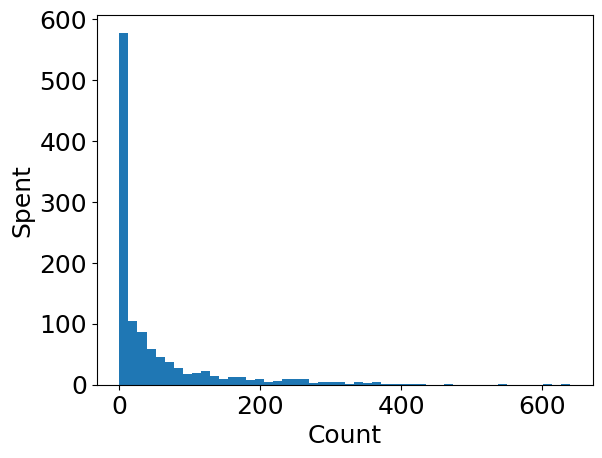

In [27]:
# Plot a histogram of the 'Spent' column
plt.hist(advertising['Spent'], bins=50)
plt.xlabel('Count')
plt.ylabel('Spent')
plt.show()

In [28]:
# The Box-Cox transformation requires all data to be positive. 
# Assuming that 'Spent' has no negative values:

# Add a small constant to avoid zero
advertising['Spent'] = advertising['Spent'] + 1

# Apply Box-Cox transformation
advertising['Spent'], _ = stats.boxcox(advertising['Spent'])

# Check the skewness 
print(advertising['Spent'].skew())


0.018448937786757425


<Axes: xlabel='Spent', ylabel='Density'>

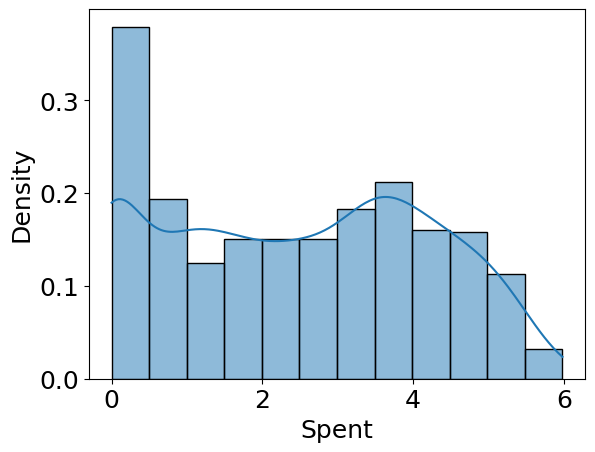

In [29]:
# Histogram
sns.histplot(advertising['Spent'], kde=True, stat='density')


In [30]:
#Pearson correlation coefficient
correlations = advertising.corr(method='pearson')
correlations

,ad_id,xyzID,fbID,gender,interest,impr,Clicks,Spent,conv,appConv
ad_id,1.000000,0.929892,0.972002,-0.058324,0.456483,0.462308,0.431981,0.667291,0.346539,0.271331
xyzID,0.929892,1.000000,0.872392,-0.086118,0.272282,0.495273,0.469729,0.741597,0.346684,0.284968
fbID,0.972002,0.872392,1.000000,-0.038037,0.595753,0.439439,0.406978,0.636527,0.344170,0.257658
gender,-0.058324,-0.086118,-0.038037,1.000000,0.047230,0.067059,0.168725,0.103806,0.027559,-0.025350
interest,0.456483,0.272282,0.595753,0.047230,1.000000,0.101973,0.088706,0.168422,0.120270,0.058353
impr,0.462308,0.495273,0.439439,0.067059,0.101973,1.000000,0.948514,0.737279,0.812838,0.684249
Clicks,0.431981,0.469729,0.406978,0.168725,0.088706,0.948514,1.000000,0.743484,0.694632,0.559526
Spent,0.667291,0.741597,0.636527,0.103806,0.168422,0.737279,0.743484,1.000000,0.521024,0.418838
conv,0.346539,0.346684,0.344170,0.027559,0.120270,0.812838,0.694632,0.521024,1.000000,0.864034
appConv,0.271331,0.284968,0.257658,-0.025350,0.058353,0.684249,0.559526,0.418838,0.864034,1.000000


Simple Linear Regression:

In [31]:
X = advertising['Clicks']
Y = advertising['Spent']

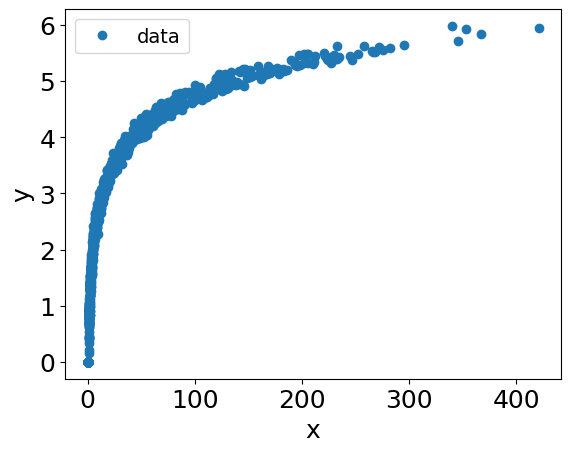

In [32]:
# Let's first plot (x,y) and see what it looks like
plt.plot('Clicks','Spent',data = advertising, marker = 'o', linestyle = '', label = 'data')
plt.xlabel('x',fontsize = 18)
plt.ylabel('y', fontsize = 18)
plt.legend(fontsize = 14)
plt.show()

500 iterations
Updated coefficients [0.006575304696960747, 0.03563205917219651]
Cost(MSE): 3.4694116034551508
Current accuracy is : 0.4074900901472792


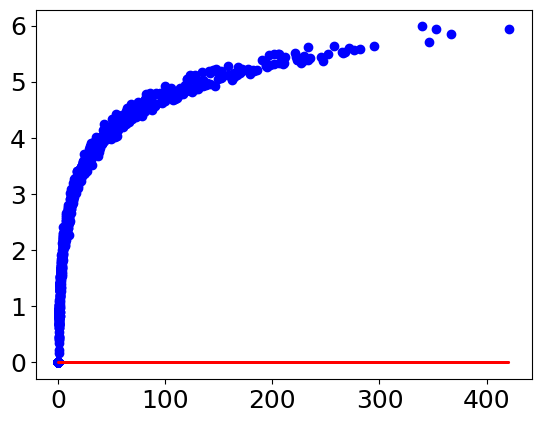

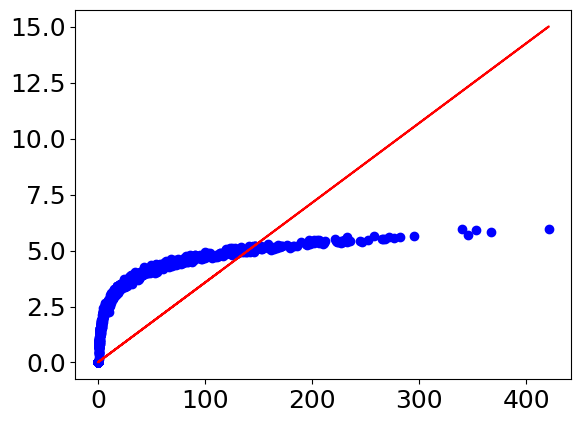

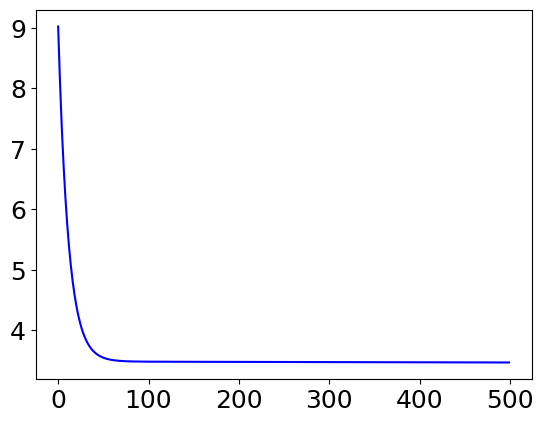

In [33]:

class Linear_Regression:
	def __init__(self, X, Y):
		self.X = X
		self.Y = Y
		self.b = [0, 0] #np.random.rand(2)
	

	# Parameter Updation
	def update_coeffs(self, learning_rate):
		Y_pred = self.predict()
		Y = self.Y
		m = len(Y)
		
			
			# b = b - (learning_rate * (dJ/db))
			# The trace of A is the sum of its diagonal entries
		self.b[0] = self.b[0] - (learning_rate * ((1/m) *
								np.sum(Y_pred - Y)))

		self.b[1] = self.b[1] - (learning_rate * ((1/m) *
								np.sum((Y_pred - Y) * self.X)))
		
		return self.b
		
	#prediction function: (y) = beta_0 + (beta_1 * x) adding 
	def predict(self, X=[]):
		Y_pred = np.array([])
		if not X: X = self.X
		b = self.b
		for x in X:
			Y_pred = np.append(Y_pred, b[0] + (b[1] * x)) 
		return Y_pred
	
	def get_current_accuracy(self, Y_pred):
		p, e = Y_pred, self.Y
		n = len(Y_pred)
		return 1-sum(
			[
				abs(p[i]-e[i])/e[i]
				for i in range(n)
				if e[i] != 0]
		)/n
	
	# MSE: GS
	def compute_cost(self, Y_pred):
		m = len(self.Y)
		J = 1/(m) * np.sum((Y_pred - Y)**2)
		return J

	


	def plot_best_fit(self, Y_pred, fig):
				f = plt.figure(fig)
				plt.scatter(self.X, self.Y, color='b')
				plt.plot(self.X, Y_pred, color='r')
				f.show()
    
    

X = np.array([x for x in X])
Y = np.array([y for y in Y])


def main():
    regressor = Linear_Regression(X, Y)
    iterations = 0
    steps = 500
    learning_rate = 0.00001
    costs = [] #mse
    updated_b = []  # store updated values of b
    
    

    #original best-fit line
    Y_pred = regressor.predict()
    regressor.plot_best_fit(Y_pred, 'Initial Best Fit Line')
    
    while 1:
        Y_pred = regressor.predict()
        cost = regressor.compute_cost(Y_pred)
        costs.append(cost)
        
        
        updated_b = regressor.update_coeffs(learning_rate)  # get updated values of b
        iterations += 1

        if iterations % steps == 0:
            print(iterations, "iterations")
            
            
            
            stop = input("Do you want to stop (y/*)??")
            if stop == "y":
                break
 
            
            # Check for convergence
        if len(costs) >= 2 and abs(costs[-1] - costs[-2]) < 1e-7:
            print("Converged at iteration:", iterations)
            break
            

            
    
    print("Updated coefficients", updated_b)  # print updated values of b for last iteration
    print("Cost(MSE):", cost)
    print("Current accuracy is :",
                  regressor.get_current_accuracy(Y_pred))
   
    #final best-fit line
    regressor.plot_best_fit(Y_pred, 'Final Best Fit Line')

    #plot to verify cost function decreases
    h = plt.figure('Verification')
    plt.plot(range(iterations), costs, color='b')
    h.show()

    # if user wants to predict using the regressor:
    #regressor.predict([i for i in range(0)])
    
    

if __name__ == '__main__':
    main()


In [34]:
#Creating additional features: 
#advertising.fillna(0, inplace=True)
advertising['CTR'] = 100 * advertising['Clicks'] / advertising['impr']
advertising['CPC'] = advertising['Spent'] / advertising['Clicks']
advertising['CPI'] = advertising['Spent'] / advertising['impr']
advertising.head()

,ad_id,xyzID,fbID,age,gender,interest,impr,Clicks,Spent,conv,appConv,CTR,CPC,CPI
0,708746,916,103916,32,0,15,7350,1,0.878416,2,1,0.013605,0.878416,0.000120
1,708749,916,103917,32,0,16,17861,2,1.023834,2,0,0.011198,0.511917,0.000057
2,708771,916,103920,32,0,20,693,0,0.000000,1,0,0.000000,NaN,0.000000
3,708815,916,103928,32,0,28,4259,1,0.803021,1,0,0.023480,0.803021,0.000189
4,708818,916,103928,32,0,28,4133,1,0.820297,1,1,0.024195,0.820297,0.000198


In [35]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
# Fill in any missing values with 0
advertising.fillna(0, inplace=True)

# Prepare the data for linear regression
X = advertising[['Clicks','age','gender', 'impr', 'interest', 'conv', 'ad_id','xyzID','fbID',	'appConv']]
Y = advertising['Spent']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalize the input features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [36]:
print(X.shape)
print(X_test.shape)
print(Y_test.size)
print(Y.size)

(1143, 10)
(229, 10)
229
1143


Multi Linear regression:

In [37]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Fill in any missing values with 0
advertising.fillna(0, inplace=True)

# Prepare the data for linear regression
X = advertising[['Clicks','age','gender', 'impr', 'interest', 'conv', 'ad_id','xyzID','fbID',	'appConv']]
Y = advertising['Spent']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalize the input features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Print the intercept and coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Make predictions on the training set
Y_train_pred = model.predict(X_train)

# Calculate the mean squared error on the training set
ml_train_mse = mean_squared_error(Y_train, Y_train_pred)
ml_train_rmse = np.sqrt(ml_train_mse)

# Calculate the R-squared value for the training set
ml_train_r2 = r2_score(Y_train, Y_train_pred)


# Make predictions on the test set
Y_test_pred = model.predict(X_test)

# Calculate the mean squared error on the test set
ml_test_mse = mean_squared_error(Y_test, Y_test_pred)
ml_test_rmse = np.sqrt(ml_test_mse)

# Calculate the R-squared value for the test set
ml_test_r2 = r2_score(Y_test, Y_test_pred)



print("Training MSE:", ml_train_mse)
print("Test MSE:", ml_test_mse)
print("Training R-squared value:", ml_train_r2)
print("Test R-squared value:", ml_test_r2)
print("Training RMSE:", ml_train_rmse)
print("Test RMSE:", ml_test_rmse)

Intercept: 2.495990259473279
Coefficients: [ 2.30261374e-01  2.39405271e-01  1.72696936e-01  6.27509848e-01
 -4.37545659e-02 -6.20327393e-02 -8.13231674e-01  1.23423269e+00
  4.90405123e-01  7.06580211e-04]
Training MSE: 0.6452442000469353
Test MSE: 0.6877347101738683
Training R-squared value: 0.7846956678159756
Test R-squared value: 0.7686606660569559
Training RMSE: 0.8032709381316713
Test RMSE: 0.8292977210711895


In [38]:
print(Y_train.shape)
print(Y_test.shape)
print(Y_train_pred.shape)
print(Y_test_pred.shape)


(914,)
(229,)
(914,)
(229,)


Ridge and Lasso:

In [39]:

# Prepare the data for linear regression
#advertising.fillna(0, inplace=True)
X = advertising[['Clicks','age','gender', 'impr', 'interest', 'conv', 'ad_id','xyzID','fbID', 'appConv']]
Y = advertising['Spent']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# normalizing the data by subtracting the mean and dividing by the standard deviation may not work well with outliers since they can skew the mean and standard deviation values.

# Normalize the input features. 
#X_train = (X_train - X_train.mean()) / X_train.std()
#X_test = (X_test - X_test.mean()) / X_test.std()


# StandardScaler method not only normalizes the data but also standardizes it by subtracting the mean and dividing by the standard deviation, which is useful in cases where the data may have different scales or units. Additionally, the StandardScaler method can handle outliers well since it uses the mean and standard deviation to scale the data.

# Create a StandardScaler object
scaler = StandardScaler()
# Fit the scaler on the training data and transform the data
X_train = scaler.fit_transform(X_train)
# Transform the testing data using the fitted scaler
X_test = scaler.transform(X_test)


# Initialize the hyperparameters
alpha = 0.01
num_iters = 100
ridge_alpha = 0.01

# Create a Ridge model and fit it on the training data
ridge_model = Ridge(alpha=ridge_alpha)
ridge_model.fit(X_train, Y_train)

# Print the model parameters and R-squared value
Y_pred = ridge_model.predict(X_test)
Ridge_mse = np.mean((Y_test - Y_pred) ** 2)
Ridge_r2 = r2_score(Y_test, Y_pred)
print("Ridge regression")
print("Intercept:", ridge_model.intercept_)
print("Coefficients:", ridge_model.coef_)
print("MSE:", Ridge_mse)
print("R-squared value:", Ridge_r2)
Ridge_rmse = np.sqrt(Ridge_mse)
print("Regression RMSE:", Ridge_rmse) 

# Create a Lasso model and fit it on the training data
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, Y_train)

# Print the model parameters and R-squared value
Y_pred = lasso_model.predict(X_test)
Lasso_mse = np.mean((Y_test - Y_pred) ** 2)
Lasso_r2 = r2_score(Y_test, Y_pred)
print("\nLasso regression")
print("Intercept:", lasso_model.intercept_)
print("Coefficients:", lasso_model.coef_)
print("MSE:", Lasso_mse)
print("R-squared value:", Lasso_r2)
Lasso_rmse = np.sqrt(Lasso_mse)
print("Regression RMSE:", Lasso_rmse)

Ridge regression
Intercept: 2.495990259473279
Coefficients: [ 2.30327355e-01  2.39409130e-01  1.72686079e-01  6.27429245e-01
 -4.36991961e-02 -6.19961093e-02 -8.12515749e-01  1.23400581e+00
  4.89865286e-01  6.97776835e-04]
MSE: 0.6877435740567783
R-squared value: 0.7686576844352082
Regression RMSE: 0.8293030652643087

Lasso regression
Intercept: 2.495990259473279
Coefficients: [ 0.2794192   0.24184319  0.15867333  0.53186582  0.         -0.
 -0.15958241  1.03399584  0.         -0.00367089]
MSE: 0.7092588344589484
R-squared value: 0.761420408291634
Regression RMSE: 0.8421750616462995


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class MultiLinearRegression:
    def __init__(self, X, Y):
        self.X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.Y = Y.values.reshape(-1, 1)
        self.b = np.zeros((self.X.shape[1], 1))

    def update_coeffs(self, learning_rate):
        Y_pred = self.predict()
        m = len(self.Y)
        error = Y_pred - self.Y
        gradient = (1/m) * np.dot(self.X.T, error)
        self.b -= learning_rate * gradient
        return self.b

    def predict(self, X=None):
        if X is None:
            X = self.X
        return np.dot(X, self.b)

    def compute_cost(self, Y_pred):
        m = len(self.Y)
        J = (1/(2*m)) * np.sum((Y_pred - self.Y)**2)
        return J

    def r_squared(self, Y_pred):
        sse = np.sum((self.Y - Y_pred)**2)
        sst = np.sum((self.Y - np.mean(self.Y))**2)
        r2 = 1 - (sse/sst)
        return r2

    def plot_best_fit(self, Y_pred, fig):
        f = plt.figure(fig)
        plt.scatter(self.X[:, 1], self.Y, color='b')
        plt.plot(self.X[:, 1], Y_pred, color='r')
        f.show()

advertising.fillna(0, inplace=True)

# Prepare the data for linear regression
#X = advertising[['Clicks', 'impr', 'interest', 'conv', 'ad_id','xyzID','fbID',	'appConv',	'CTR',	'CPC',	'CPI']]
X = advertising[['Clicks', 'impr', 'conv', 'ad_id', 'appConv']]
Y = advertising['Spent']


# Normalize the input features
X = (X - X.mean()) / X.std()

regressor = MultiLinearRegression(X, Y)

iterations = 0
steps = 500
learning_rate = 0.1
convergence_threshold = 1e-6
costs = []
updated_b = []



while 1:
    Y_pred = regressor.predict()
    r2 = regressor.r_squared(Y_pred)
    cost = regressor.compute_cost(Y_pred)
    costs.append(cost)

    updated_b = regressor.update_coeffs(learning_rate)
    iterations += 1

    if iterations % steps == 0:
        print("Iteration:", iterations)
        
        stop = input("Do you want to stop (y/*)??")
        if stop == "y":
            break
        
        if len(costs) >= 2 and np.abs(cost - costs[-2])<1e-9:
            print("Converged at iteration:", iterations)  
            break

mse = mean_squared_error(Y, Y_pred)
print("Updated b:", updated_b.ravel())
print("Cost:", cost)
print("R-squared:", r2)
print("Mean squared error:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

Iteration: 500
Updated b: [ 2.45425169  0.6650666   0.46800271 -0.19265809  0.71786856  0.00491236]
Cost: 0.4433886678150647
R-squared: 0.7043117194794197
Mean squared error: 0.8867773356301294
RMSE: 0.9416885555374077


In [41]:
# Fill in any missing values with 0
advertising.fillna(0, inplace=True)

from sklearn.preprocessing import StandardScaler

# Prepare the data for linear regression
X = advertising[['Clicks','age','gender', 'impr', 'interest', 'conv', 'ad_id','xyzID','fbID',	'appConv']]
Y = advertising['Spent']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalize the input features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Add a column of ones for the bias term
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

# Initialize the model parameters
theta = np.zeros(X_train.shape[1])

# Set the learning rate and number of iterations
alpha = 0.1
num_iters = 1000

# Define the cost function
def compute_cost(X, Y, theta):
    m = Y.shape[0]
    J = 1 / (2*m) * np.sum((np.dot(X, theta) - Y) ** 2)
    return J

# Define the gradient descent algorithm
def gradient_descent(X, Y, theta, alpha, num_iters):
    m = Y.shape[0]
    J_history = np.zeros(num_iters)
    for i in range(num_iters):
        theta -= alpha * (1 / m) * np.dot(X.T, (np.dot(X, theta) - Y))
        J_history[i] = compute_cost(X, Y, theta)
    return theta, J_history

# Fit the linear regression model using gradient descent
theta, J_history = gradient_descent(X_train, Y_train, theta, alpha, num_iters)

# Make predictions on the test/train set
Y_pred_test = np.dot(X_test, theta)
Y_pred_train = np.dot(X_train, theta)

# Calculate evaluation metrics on both training and test sets
mse_train = np.mean((Y_pred_train - Y_train)**2)
mse_test = np.mean((Y_pred_test - Y_test)**2)
tss_test = np.sum((Y_test - Y_test.mean())**2)
rss_test = np.sum((Y_test - Y_pred_test)**2)
r_squared_test = 1 - (rss_test / tss_test)
tss_train = np.sum((Y_train - Y_train.mean())**2)
rss_train = np.sum((Y_train - Y_pred_train)**2)
r_squared_train = 1 - (rss_train / tss_train)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Print the model parameters, final cost, and evaluation metrics
print("Intercept:", theta[0])
print("Coefficients:", theta[1:])
print("Final cost:", J_history[-1])
print('MSE on training set:', mse_train)
print('MSE on test set:', mse_test)
print('R-squared on training set:', r_squared_train)
print('R-squared on test set:', r_squared_test)
print("RMSE on training set:", rmse_train)
print("RMSE on test set:", rmse_test)


Intercept: 2.495990259473277
Coefficients: [ 0.23334695  0.24234958  0.17217469  0.62264562 -0.01340675 -0.05341648
 -0.5988512   1.19836778  0.29114249 -0.00364422]
Final cost: 0.3231804468098931
MSE on training set: 0.6463608936197862
MSE on test set: 0.6933462311641785
R-squared on training set: 0.7843230508068814
R-squared on test set: 0.7667730697075184
RMSE on training set: 0.8039657291326454
RMSE on test set: 0.8326741446473395


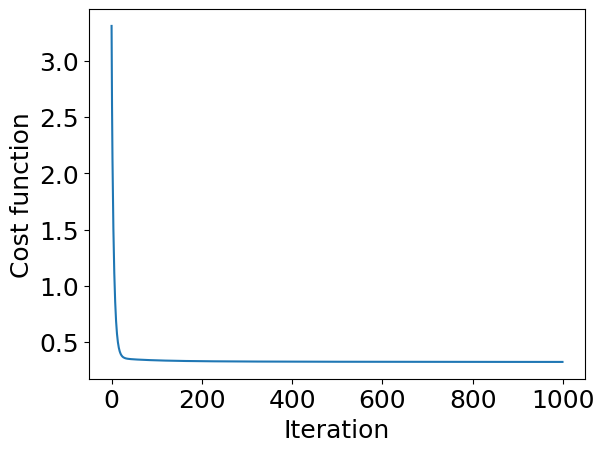

In [42]:
# Plot the cost function over time
plt.plot(np.arange(num_iters), J_history)
plt.xlabel("Iteration")
plt.ylabel("Cost function")
plt.show()

In [45]:
# Create a table of the mean squared error and R-squared value for all models
table = [["The ordinary least squares: Training", round
          (ml_train_mse, 2), round(ml_train_r2*100, 2), round(ml_test_rmse, 2)]
         ,["The ordinary least squares: Testing", round(ml_test_mse, 2), round(ml_test_r2*100, 2), round(ml_test_rmse, 2)],
         #["Ridge regression", round(Ridge_mse, 2), round(Ridge_r2*100, 2), round(Ridge_rmse, 2)],
         #["Lasso regression", round(Lasso_mse, 2), round(Lasso_r2*100, 2), round(Lasso_rmse, 2)],
         ["Gradient descent: Training", round(mse_train, 2), round(r_squared_test*100, 2), round(rmse_train, 2)],
         ["Gradient descent: Testing", round(mse_test, 2), round(r_squared_train*100, 2), round(rmse_test, 2)]]

print(tabulate(table, headers=["Model: Linear regression", "MSE", "R-squared(%)", "RMSE"], tablefmt="pretty"))

#Root Mean Squared Erro

+--------------------------------------+------+--------------+------+
|       Model: Linear regression       | MSE  | R-squared(%) | RMSE |
+--------------------------------------+------+--------------+------+
| The ordinary least squares: Training | 0.65 |    78.47     | 0.83 |
| The ordinary least squares: Testing  | 0.69 |    76.87     | 0.83 |
|      Gradient descent: Training      | 0.65 |    76.68     | 0.8  |
|      Gradient descent: Testing       | 0.69 |    78.43     | 0.83 |
+--------------------------------------+------+--------------+------+
